# AutoGenU for Jupyter

An Automatic C++ Code Generator for Nonlinear Model Predictive Control (NMPC)  

---  

## Formulation of the optimal control problem: Cart pole

### Model description
<img src="https://raw.github.com/wiki/mayataka/CGMRES/images/fig_cartpole.png" width=40%>

The above figure shows the model of a cart pole. By the Lagrange's method, the equation of the motion is derived as  
$$\ddot{y} = \frac{1}{m_c + m_p \sin ^2{\theta}} \left\{ u + m_p \sin{\theta} (l \dot{\theta}^2 + g \cos{\theta}) \right\}, $$  
$$\ddot{\theta} = \frac{1}{l(m_c + m_p \sin ^2{\theta})} \left\{ - u \cos{\theta} - m_p l {\dot{\theta}}^2 \cos{\theta} \sin{\theta} - (m_c + m_p) g \sin{\theta} \right\} .$$
We also assume that the input of the cartpole is limited as  
$$u_{\rm min} \leq u \leq u_{\rm max} , $$
where $u_{\rm min}, u_{\rm max} \in \mathbb{R}$.

### Formulation of the optimal control problem
We define the state vector as
$$ x = \begin{bmatrix} y \\ \theta \\ \dot{y} \\ \dot{\theta} \end{bmatrix} .$$
The state equation is then given as 
$$\dot{x} = f(t, x, u) = \begin{bmatrix} \dot{y} \\ \dot{\theta} \\ \frac{1}{m_c + m_p \sin ^2{\theta}} \left\{ u + m_p \sin{\theta} (l \dot{\theta}^2 + g \cos{\theta}) \right\} \\ \frac{1}{l(m_c + m_p \sin ^2{\theta})} \left\{ - u \cos{\theta} - m_p l {\dot{\theta}}^2 \cos{\theta} \sin{\theta} - (m_c + m_p) g \sin{\theta} \right\} \end{bmatrix} .$$
Next, we set the cost function 
$$ J = \varphi(t, x) + \int_{t}^{t+T} L(t, x, u) .$$
The objective is to invert the pole and stabilize the cart around $y=0$. In other words, we want to converge the state of the cart pole to 
$$x_{\rm ref} := \begin{bmatrix} 0 \\ \pi \\ 0 \\ 0 \end{bmatrix}.$$  
To achieve this goal, we set the terminal cost as
$$\varphi(t,x) = \frac{1}{2} (x - x_{\rm ref})^{\rm T} Q_{\rm terminal} (x - x_{\rm ref}) ,$$  
where $Q_{\rm terminal} = {\rm diag}\left\{ {q_{\rm terminal}}_1, {q_{\rm terminal}}_2, {q_{\rm terminal}}_3, {q_{\rm terminal}}_4 \right\}$ and ${q_{\rm terminal}}_1, {q_{\rm terminal}}_2, {q_{\rm terminal}}_3, {q_{\rm terminal}}_4$ are positive real constants. We also set the stage cost as  
$$L(t, x, u) = \frac{1}{2} (x - x_{\rm ref})^{\rm T} Q (x - x_{\rm ref}) + \frac{1}{2} r u^2,$$  
where $Q = {\rm diag} \left\{ q_1, q_2, q_3, q_4 \right\}$ with positive real constants $q_1, q_2, q_3, q_4$, $r$ is positive real constant.

---

# Generate C++ codes of NMPC model  

## Import module

In [1]:
import autogenu

## Set dimensions and define `AutoGenU`
- `nx`: Dimension of the state vector $x$   
- `nu`: Dimension of the control input vector $u$  
- `ocp_name`: Name of the optimal control problem (OCP). Used as the name of the directory containing the generated C++ source files.

In [2]:
nx = 4
nu = 1
ocp_name = 'cartpole'
ag = autogenu.AutoGenU(ocp_name, nx, nu)

## Generate t, x, and u, necessary variables to formulate of the optimal control problem
- `t`: Time parameter $t$  
- `x`: The state vector $x$  
- `u`: The control input vector $u$  

In [3]:
t = ag.define_t()
x = ag.define_x()
u = ag.define_u()

## Define variables used in the state equation, constraints, and cost function
- Define a scalar variable whose name is "var" as  
`var = ag.define_scalar_var('var') `

- Define scalar variables whose names are "var\_1", "var\_2", ..., "var\_n" as  
`var_1, var_2, ..., var_n = ag.define_scalar_vars('var_1', 'var_2', ..., 'var_n')`

- Define array variables whose name is "vec" and dimension is dim_vec as  
`vec = ag.define_array_var('vec', dim_vec)`

In [4]:
# Variables used in the state function
m_c, m_p, l, g = ag.define_scalar_vars('m_c', 'm_p', 'l', 'g')

# Variables used in the cost function
q = ag.define_array_var('q', nx)
q_terminal = ag.define_array_var('q_terminal', nx)
x_ref = ag.define_array_var('x_ref', nx)
r = ag.define_array_var('r', nu)

## Define the state equation, constraints, the stage cost, and the terminal cost
- `f`: The state equation $ f(t, x, u)$  
- `C`: The equality constraisnts $C(t, x, u) = 0 $  
- `h`: The inequality constraisnts $h(t, x, u) \leq 0$ considered by semi-smooth Fischer-Burumeister method  
- `L`: The stage cost $L(t, x, u)$  
- `phi`: The terminal cost $\phi (t, x)$  

Note: array indices start with 0

In [5]:
# Import symbolic math from sympy. If you need more functions, import same as below.
from sympy import sin, cos, tan, exp, log, sinh, cosh, tanh, diff, sqrt

In [6]:
# Define the state equation
f = [x[2], 
     x[3],
    (u[0] + m_p*sin(x[1])*(l*x[1]*x[1] + g*cos(x[1])) )/( m_c+m_p*sin(x[1])*sin(x[1])),
    (-u[0] * cos(x[1]) - m_p*l*x[1]*x[1]*cos(x[1])*sin(x[1]) - (m_c+m_p)*g*sin(x[1]) )/( l*(m_c + m_p*sin(x[1])*sin(x[1])))]

# Define the constraints
C = []

# Define the inequality constraints considered using the semi-smooth Fischer-Burmeister method
h = []

# Define the stage cost
L = sum(q[i]*(x[i] - x_ref[i])**2 for i in range(nx))/2 + (r[0] * u[0]**2)/2  

# Define the terminal cost
phi = sum(q_terminal[i]*(x[i] - x_ref[i])**2 for i in range(nx))/2 

In [7]:
# Set functions
ag.set_functions(f, C, h, L, phi)

## Define the control input bound constraints
The box constraints on the control input $u_{\rm min} \leq u \leq u_{\rm max}$ are treated in a special manner.
Specifically, it is transformed into $$u^2 + u_{\rm dummy}^2 - (\frac{u_{\rm max} - u_{\rm min}}{2})^2 = 0$$.  
Further, $u_{\rm dummy}$ and associated Lagrange multiplier are eliminated in Newton-type iteration efficiently in the multiple-shooting solver.  
Set such box constraints by specifying
- `uindex`: index of the constrained control input element
- `umin`: Minimum value (lower bound) of the control input element
- `umax`: Maximum value (upper bound) of the control input element
- `dummy_weight`: Weight parameter of the dummy (slack) variable

In [8]:
ag.add_control_input_bounds(uindex=0, umin=-15.0, umax=15.0, dummy_weight=0.1)

## Set Parameters
Set values for all parameters you defined.
- Set `value` for a scalar variable whose name is "var" as  
`ag.set_scalar_var('var', value) `

- Set `value_1`, `value_2`, ..., `value_n`, for scalar variables whose names are "var\_1", "var\_2", ..., "var\_n" as  
`ag.set_scalar_vars(['var_1', value_1], ['var_2', value_2], ..., ['var_n', value_n])`

- Set array variables `var_1`, `var_2`, ..., `var_n` whose name is "vec" and dimension is n as  
`ag.define_array_var('vec', [var_1, var_2, ..., var_n])`

In [9]:
ag.set_scalar_vars(['m_c', 2], ['m_p', 0.2], ['l', 0.5], ['g', 9.80665])
ag.set_array_var('q', [2.5, 10, 0.01, 0.01])
ag.set_array_var('r', [1])
ag.set_array_var('q_terminal', [2.5, 10, 0.01, 0.01])
ag.set_array_var('x_ref', [0, 'M_PI', 0, 0])

## Generate C++ codes of the definition of the optimal control problem
Generate `ocp.hpp` that defines the optimal control problem (OCP).  
- `simplification`: The flag for simplification. If `True`, symbolic functions are simplified. However, if functions are too complicated, it takes too much time. Default is `False`.  
- `common_subexpression_elimination`: The flag for common subexpression elimination. If `True`, common subexpressions in fxu, phix, hx, and hu are eliminated when `ocp.hpp` is generated. Default is `False`. 

In [10]:
simplification = False
common_subexpression_elimination = True

ag.generate_ocp_definition(simplification, common_subexpression_elimination)

'ocp.hpp', the definition of the OCP, is generated at /home/sotaro/src/autogenu-jupyter/generated/cartpole/ocp.hpp


---  
# Generate C++ codes of NMPC solver and numerical simulation  

## Set NLP type  
Set which NLP formulation you use. (hint: `MultipleShooting` works better for typical nonlinear problems.)
- `MultipleShooting` (recommended) : The multiple shooting based C/GMRES method with condensing of the state and the Lagragne multipliers with respect to the state equation.
- `SingleShooting` : The single shooting method, i.e., the original C/GMRES method.

In [11]:
nlp_type = autogenu.NLPType.MultipleShooting
ag.set_nlp_type(nlp_type)

## Set horizon length 

- `Tf`, `alpha`: Parameters for the length of the horizon. If $\alpha > 0$, time-varying horizon length $T(t) = T_f (1 - e^{-\alpha t})$ is used. Otherwise, $T(t)$ is fixed by $T_f$. 

In [12]:
Tf = 2.0
alpha = 0.0

ag.set_horizon_params(Tf, alpha)

## Set parameters for the C/GMRES method

- `sampling_time`: Sampling period.
- `N`: The number of the discretization grids of the horzion.  
- `finite_difference_epsilon`: Step length of a finite difference approximations of hessian-vector products in C/GMRES.   
- `zeta`: A stabilization parameter of the C/GMRES method. Basically, must be set by the reciprocal of the sampling time.  
- `kmax`: The maximam number of the iteration of the GMRES.

In [13]:
sampling_time = 0.001
N = 100
finite_difference_epsilon = 1.0e-08
zeta = 1000  
kmax = 5

ag.set_solver_params(sampling_time, N, finite_difference_epsilon, zeta, kmax)

## Set parameters for the initialization of the solution  
- `solution_initial_guess`: The initial guess of the solution of the optimal control problem (OCP) for initialization of the solution of NMPC.   
- `tolerance`: The residual tolerance of the solution of the OCP for the initialization of the solution of NMPC. The Newton iteration terminates when the optimality error is less than this velue.  
- `max_iterations`: The maxmum number of Newton iteration for the initialization of the solution of NMPC.  

In [14]:
solution_initial_guess = [0.01]
tolerance = 1.0e-06
max_iterations = 50

ag.set_initialization_params(solution_initial_guess, tolerance, max_iterations)

## Set parameters for numerical simulation
- `initial_time`: Initial time of the numerical simulation.  
- `initial_state`: Initial state vector of the system.  
- `simulation_length`: Simulation length.  

In [15]:
initial_time = 0  
initial_state = [0, 0, 0, 0]  
simulation_length = 10

ag.set_simulation_params(initial_time, initial_state, simulation_length) 

## Generate main.cpp and CMakeLists.txt

In [16]:
ag.generate_main()
ag.generate_cmake()

'main.cpp', the closed-loop simulation code, is generated at /home/sotaro/src/autogenu-jupyter/generated/cartpole/main.cpp
CMakeLists.txt are generated at /home/sotaro/src/autogenu-jupyter/generated/cartpole


## Build and run simulation

- `generator`: An optional variable for Windows user to choose the generator of CMake. If 'MSYS', then 'MSYS Makefiles' is used. If 'MinGW', then 'MinGW Makefiles' is used. The default value is 'Auto' and the generator is selected automatically. If sh.exe exists in your PATH, MSYS is choosed, and otherwise MinGW is used. 
- `remove_build_dir`: If `True`, the existing build directory is removed. If `False`, the build directory is not removed. Need to be set `True` if you change the generator. Default is `False`.

In [17]:
generator = 'Auto'  
remove_build_dir = False
ag.git_submodule_update()
ag.build_main(generator, remove_build_dir)
ag.run_simulation()

CMake options: -DCMAKE_BUILD_TYPE=Release -DVECTORIZE=ON -DBUILD_MAIN=ON -DBUILD_PYTHON_INTERFACE=OFF
-- The CXX compiler identification is GNU 9.4.0
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done
-- Generating done
-- Build files have been written to: /home/sotaro/src/autogenu-jupyter/generated/cartpole/build


Scanning dependencies of target cartpole
[ 50%] Building CXX object CMakeFiles/cartpole.dir/main.cpp.o
[100%] Linking CXX executable cartpole
[100%] Built target cartpole


Start simulation
End simulation
Total CPU time for control update: 827.55 [ms]
sampling time: 1 [ms]
CPU time for per control update: 0.082755 [ms]


## Plot the simulation results

In [18]:
%matplotlib inline

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


The graph of the simlation results is generated at /home/sotaro/src/autogenu-jupyter/generated/cartpole/simulation_result/cartpole.pdf


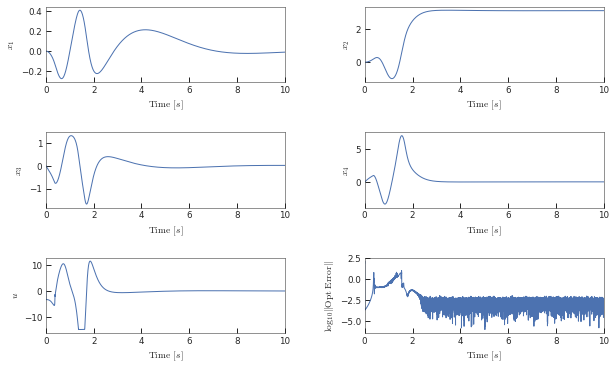

In [19]:
plotsim = autogenu.PlotSimulation(ocp_name)
plotsim.set_scales(2,5,2)
# plotsim.show_plots()
plotsim.save_plots()

## Draw animations of the simulation results

In [20]:
anim = autogenu.CartPole(ocp_name)
anim.set_skip_frames(10)
# anim.generate_animation()

## Build Python interface

- `generator`: An optional variable for Windows user to choose the generator of CMake. If 'MSYS', then 'MSYS Makefiles' is used. If 'MinGW', then 'MinGW Makefiles' is used. The default value is 'Auto' and the generator is selected automatically. If sh.exe exists in your PATH, MSYS is choosed, and otherwise MinGW is used. 
- The python interfaces will be installed at `~/.local/lib/python3.x`. If you use MacOSX or Windows, add it to the Python PATH as 
```
export $PYTHONPATH=$PYTHONPATH:$HOME/.local/lib/python3.x/site-packages
```
where `python3.x` is your python version

In [21]:
generator = 'Auto'  
ag.generate_python_bindings()
ag.git_submodule_update()
ag.build_python_interface(generator)

pybind11 source codes are generated at /home/sotaro/src/autogenu-jupyter/generated/cartpole/python
CMake options: -DCMAKE_BUILD_TYPE=Release -DVECTORIZE=ON -DBUILD_MAIN=OFF -DBUILD_PYTHON_INTERFACE=ON
-- pybind11 v2.11.0 dev1
-- Found PythonInterp: /usr/bin/python3 (found suitable version "3.8.10", minimum required is "3.6")
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- pybind11 v2.11.0 dev1
-- Configuring done
-- Generating done
-- Build files have been written to: /home/sotaro/src/autogenu-jupyter/generated/cartpole/build


Scanning dependencies of target horizon
Scanning dependencies of target solver_settings
Scanning dependencies of target timer
Scanning dependencies of target multiple_shooting_cgmres_solver
Scanning dependencies of target single_shooting_cgmres_solver
Scanning dependencies of target zero_horizon_ocp_solver
Scanning dependencies of target ocp
[  7%] Building CXX object python/comm

[ 57%] Linking CXX shared library solver_settings.cpython-38-x86_64-linux-gnu.so
[ 64%] Linking CXX shared library horizon.cpython-38-x86_64-linux-gnu.so
[ 71%] Linking CXX shared library timer.cpython-38-x86_64-linux-gnu.so
[ 78%] Linking CXX shared library ocp.cpython-38-x86_64-linux-gnu.so
[ 85%] Linking CXX shared library zero_horizon_ocp_solver.cpython-38-x86_64-linux-gnu.so
[ 92%] Linking CXX shared library single_shooting_cgmres_solver.cpython-38-x86_64-linux-gnu.so
[ 92%] Built target solver_settings
[ 92%] Built target horizon
[ 92%] Built target timer
[100%] Linking CXX shared library multiple_shooting_cgmres_solver.cpython-38-x86_64-linux-gnu.so
[100%] Built target ocp
[100%] Built target zero_horizon_ocp_solver
[100%] Built target single_shooting_cgmres_solver
[100%] Built target multiple_shooting_cgmres_solver




## Install Python interface

Sometimes CMake does not recognize the built Python interfaces.   
Please re-run the following cell until CMake does so.   
The usage of Python interfaces is introduced in `examples/python` directory.

In [23]:
ag.install_python_interface()

-- Install configuration: "Release"
-- Up-to-date: /home/sotaro/.local/lib/python3.8/site-packages/cgmres/common/__init__.py
-- Installing: /home/sotaro/.local/lib/python3.8/site-packages/cgmres/common/horizon.cpython-38-x86_64-linux-gnu.so
-- Installing: /home/sotaro/.local/lib/python3.8/site-packages/cgmres/common/solver_settings.cpython-38-x86_64-linux-gnu.so
-- Installing: /home/sotaro/.local/lib/python3.8/site-packages/cgmres/common/timer.cpython-38-x86_64-linux-gnu.so
-- Up-to-date: /home/sotaro/.local/lib/python3.8/site-packages/cgmres/cartpole/__init__.py
-- Installing: /home/sotaro/.local/lib/python3.8/site-packages/cgmres/cartpole/multiple_shooting_cgmres_solver.cpython-38-x86_64-linux-gnu.so
-- Installing: /home/sotaro/.local/lib/python3.8/site-packages/cgmres/cartpole/ocp.cpython-38-x86_64-linux-gnu.so
-- Installing: /home/sotaro/.local/lib/python3.8/site-packages/cgmres/cartpole/single_shooting_cgmres_solver.cpython-38-x86_64-linux-gnu.so
-- Installing: /home/sotaro/.local